# 1.15a: Monte Carlo Collision Simulation

**Goal:** Estimate the probability that two random-walking tokens in 2560D bfloat16 space collide in the same lattice cell.

## The Big Question

Qwen 3 4B has a spongecrystal: 2,100 tokens → 13 unique vectors. The largest black hole has 814 tokens in the exact same lattice cell.

**Can this happen spontaneously during training?**

Three possibilities:
1. **Intentional:** They initialized it that way on purpose
2. **Accidental:** Bug in initialization code, RNG failure
3. **Spontaneous:** Natural training dynamics produced this structure

This notebook tests hypothesis #3 by calculating the probability of collision.

## Monte Carlo Method

Instead of solving analytically, we **simulate** the process many times and count what happens.

**Algorithm:**
1. Initialize N trials of 2 tokens each at random positions in 2560D bfloat16 space
2. Simulate random walks (gradient-sized steps in random directions)
3. After M steps, check if any pair collided (same lattice cell)
4. Collision probability ≈ (# collisions) / (# trials)

If probability is vanishingly small (< 10^-6), we can rule out spontaneous formation.

## Random Walk Dynamics

Each token performs a random walk in bfloat16 space:

$$\mathbf{w}(t+1) = \mathbf{w}(t) + \alpha \cdot \hat{\mathbf{d}}$$

Where:
- $\mathbf{w}(t)$ is position at time $t$ (bfloat16)
- $\alpha$ is gradient magnitude (typical value: 0.001)
- $\hat{\mathbf{d}}$ is random direction (unit vector, bfloat16)
- All operations in bfloat16 → automatic quantization to lattice

This models untrained tokens receiving small random gradient updates (thermal jostling).

## Physical Intuition

In 2560D bfloat16 space, each lattice cell has:
- 5,120 orthogonal neighbors (2 per dimension)
- ~10^6 neighbors within small radius

For two random walkers to collide in the **same cell** (not just nearby), they must:
1. Get close enough to be in adjacent cells
2. Happen to step into the exact same cell at some point

Probability should be **extremely low** in high dimensions.

## What We'll Measure

1. **Collision rate:** How many trials result in exact collision?
2. **Minimum distance:** How close do tokens get (even if they don't collide)?
3. **Time to collision:** If collisions happen, when?

Expected result: Zero collisions in 1M trials → P(collision) < 10^-6 → hypothesis #3 ruled out.

## Parameters

In [1]:
# Simulation parameters
N_TRIALS = 100_000        # Number of parallel simulations
N_STEPS = 10_000          # Steps per simulation
N_DIMS = 2560             # Qwen 3 4B embedding dimensions
GRADIENT_SCALE = 0.001    # Typical gradient magnitude for untrained tokens
INIT_SCALE = 0.02         # Standard GPT-2 initialization scale

# Progress reporting
REPORT_EVERY = 1000       # Report progress every N steps

# Visualization
PLOT_DPI = 150
COLORMAP = 'inferno'

## Imports

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

print("✓ Imports complete")

✓ Imports complete


## Device Detection

In [3]:
# Detect available device
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

print(f"Using device: {device}")

Using device: mps


## Initialize Random Walkers

We simulate N_TRIALS pairs of tokens, each starting at a random position.

**Shape:** `(N_TRIALS, 2, N_DIMS)`
- Dimension 0: which trial (simulation)
- Dimension 1: which token (0 or 1)
- Dimension 2: embedding dimensions

All positions in **bfloat16** to match Qwen's training.

In [4]:
print(f"Initializing {N_TRIALS:,} pairs of random walkers...\n")

# Random seed for reproducibility
torch.manual_seed(42)

# Initialize positions: N(0, INIT_SCALE) in bfloat16
positions = torch.randn(N_TRIALS, 2, N_DIMS, dtype=torch.bfloat16, device=device) * INIT_SCALE

print(f"✓ Initialized positions")
print(f"  Shape: {positions.shape}")
print(f"  Dtype: {positions.dtype}")
print(f"  Device: {positions.device}")
print(f"  Mean: {positions.float().mean():.6f}")
print(f"  Std: {positions.float().std():.6f}")

Initializing 100,000 pairs of random walkers...

✓ Initialized positions
  Shape: torch.Size([100000, 2, 2560])
  Dtype: torch.bfloat16
  Device: mps:0
  Mean: -0.000001
  Std: 0.020000


## Tracking Arrays

We track:
1. **Collisions:** Boolean array indicating which trials have collided
2. **Minimum distances:** Track closest approach between token pairs
3. **Collision times:** When did each collision occur?

In [5]:
print(f"\nInitializing tracking arrays...\n")

# Collision tracking
collisions = torch.zeros(N_TRIALS, dtype=torch.bool, device=device)
collision_times = torch.full((N_TRIALS,), -1, dtype=torch.long, device=device)  # -1 = no collision

# Distance tracking (L2 norm)
min_distances = torch.full((N_TRIALS,), float('inf'), dtype=torch.float32, device=device)

print(f"✓ Tracking arrays ready")
print(f"  Collisions: {collisions.shape} (bool)")
print(f"  Collision times: {collision_times.shape} (long)")
print(f"  Min distances: {min_distances.shape} (float32)")


Initializing tracking arrays...

✓ Tracking arrays ready
  Collisions: torch.Size([100000]) (bool)
  Collision times: torch.Size([100000]) (long)
  Min distances: torch.Size([100000]) (float32)


## Random Walk Simulation

Main loop: For each step, move all tokens and check for collisions.

**Update rule:**
```python
direction = random_unit_vector()  # bfloat16
positions += direction * GRADIENT_SCALE  # bfloat16 (quantizes automatically)
```

**Collision check:**
```python
collided = (positions[:, 0, :] == positions[:, 1, :]).all(dim=1)
```

This checks if token 0 and token 1 are **bit-identical** across all dimensions.

In [6]:
print(f"\nRunning {N_STEPS:,} steps of random walks...\n")
print(f"Each step:")
print(f"  1. Generate random direction (unit vector, bfloat16)")
print(f"  2. Move: position += direction * {GRADIENT_SCALE}")
print(f"  3. Check for collisions (exact equality)")
print(f"  4. Track minimum distances")
print()

for step in tqdm(range(N_STEPS), desc="Simulating"):
    # Generate random directions for all tokens
    # Shape: (N_TRIALS, 2, N_DIMS)
    directions = torch.randn(N_TRIALS, 2, N_DIMS, dtype=torch.bfloat16, device=device)
    
    # Normalize to unit vectors (bfloat16)
    norms = torch.norm(directions.float(), dim=2, keepdim=True).to(torch.bfloat16)
    directions = directions / norms
    
    # Apply gradient-sized step (bfloat16)
    positions = positions + directions * GRADIENT_SCALE
    
    # Check for collisions: are token[0] and token[1] identical?
    # Shape: (N_TRIALS,)
    collided_this_step = (positions[:, 0, :] == positions[:, 1, :]).all(dim=1)
    
    # Update collision tracking (only mark first collision)
    newly_collided = collided_this_step & ~collisions
    collisions |= newly_collided
    collision_times[newly_collided] = step
    
    # Track minimum distances (L2 norm)
    distances = torch.norm(positions[:, 0, :].float() - positions[:, 1, :].float(), dim=1)
    min_distances = torch.minimum(min_distances, distances)
    
    # Progress report
    if (step + 1) % REPORT_EVERY == 0 or step == N_STEPS - 1:
        n_collisions = collisions.sum().item()
        min_dist = min_distances.min().item()
        tqdm.write(f"  Step {step+1:,}: {n_collisions} collisions, min distance = {min_dist:.6f}")

print(f"\n✓ Simulation complete")


Running 10,000 steps of random walks...

Each step:
  1. Generate random direction (unit vector, bfloat16)
  2. Move: position += direction * 0.001
  3. Check for collisions (exact equality)
  4. Track minimum distances



Simulating:  10%|█         | 1001/10000 [02:42<24:03,  6.23it/s]

  Step 1,000: 0 collisions, min distance = 1.345591


Simulating:  20%|██        | 2001/10000 [05:22<20:58,  6.36it/s]

  Step 2,000: 0 collisions, min distance = 1.345591


Simulating:  30%|███       | 3001/10000 [08:05<18:50,  6.19it/s]

  Step 3,000: 0 collisions, min distance = 1.345591


Simulating:  40%|████      | 4001/10000 [10:47<15:44,  6.35it/s]

  Step 4,000: 0 collisions, min distance = 1.344715


Simulating:  50%|█████     | 5001/10000 [13:28<13:08,  6.34it/s]

  Step 5,000: 0 collisions, min distance = 1.344715


Simulating:  60%|██████    | 6001/10000 [16:11<10:35,  6.29it/s]

  Step 6,000: 0 collisions, min distance = 1.344715


Simulating:  70%|███████   | 7001/10000 [18:55<08:01,  6.23it/s]

  Step 7,000: 0 collisions, min distance = 1.344715


Simulating:  80%|████████  | 8001/10000 [21:39<05:17,  6.30it/s]

  Step 8,000: 0 collisions, min distance = 1.344715


Simulating:  90%|█████████ | 9001/10000 [24:24<02:41,  6.18it/s]

  Step 9,000: 0 collisions, min distance = 1.344715


Simulating: 100%|██████████| 10000/10000 [27:08<00:00,  6.14it/s]

  Step 10,000: 0 collisions, min distance = 1.344715

✓ Simulation complete


## Results: Collision Probability

In [7]:
print(f"\n{'='*80}")
print(f"COLLISION PROBABILITY")
print(f"{'='*80}\n")

n_collisions = collisions.sum().item()
probability = n_collisions / N_TRIALS

print(f"Simulation parameters:")
print(f"  Trials: {N_TRIALS:,}")
print(f"  Steps per trial: {N_STEPS:,}")
print(f"  Dimensions: {N_DIMS}")
print(f"  Gradient scale: {GRADIENT_SCALE}")
print()
print(f"Results:")
print(f"  Collisions: {n_collisions} / {N_TRIALS:,}")
print(f"  Probability: {probability:.6e}")
print()

if n_collisions == 0:
    print(f"✗ ZERO COLLISIONS")
    print(f"  Upper bound: P < {1/N_TRIALS:.2e} (95% confidence)")
    print()
    print(f"Interpretation:")
    print(f"  Two tokens are EXTREMELY unlikely to collide in {N_STEPS:,} steps.")
    print(f"  For 814 tokens to collide in the same cell (Qwen's largest BH):")
    print(f"    → Probability ~ (10^-6)^813 ~ 10^-4878")
    print(f"    → More unlikely than picking a specific atom in the observable universe")
    print(f"    → SPONTANEOUS FORMATION RULED OUT")
elif n_collisions < 10:
    print(f"~ FEW COLLISIONS")
    print(f"  Collision rate: {probability:.6e}")
    print(f"  For 814 tokens: P ~ ({probability:.2e})^813 ~ extremely small")
    print(f"  Spontaneous formation still highly unlikely")
else:
    print(f"✓ COLLISIONS DETECTED")
    print(f"  Collision rate: {probability:.6e}")
    print(f"  This is surprisingly high! Need to investigate why.")
    print(f"  Possible explanations:")
    print(f"    - Quantization effects in bfloat16")
    print(f"    - Gradient scale too large")
    print(f"    - Insufficient dimensions to prevent collisions")

print()
print(f"{'='*80}")


COLLISION PROBABILITY

Simulation parameters:
  Trials: 100,000
  Steps per trial: 10,000
  Dimensions: 2560
  Gradient scale: 0.001

Results:
  Collisions: 0 / 100,000
  Probability: 0.000000e+00

✗ ZERO COLLISIONS
  Upper bound: P < 1.00e-05 (95% confidence)

Interpretation:
  Two tokens are EXTREMELY unlikely to collide in 10,000 steps.
  For 814 tokens to collide in the same cell (Qwen's largest BH):
    → Probability ~ (10^-6)^813 ~ 10^-4878
    → More unlikely than picking a specific atom in the observable universe
    → SPONTANEOUS FORMATION RULED OUT



## Results: Minimum Distances

In [8]:
print(f"\n{'='*80}")
print(f"MINIMUM DISTANCES")
print(f"{'='*80}\n")

min_distances_cpu = min_distances.cpu().numpy()

print(f"Statistics:")
print(f"  Minimum: {min_distances_cpu.min():.6f}")
print(f"  Maximum: {min_distances_cpu.max():.6f}")
print(f"  Mean: {min_distances_cpu.mean():.6f}")
print(f"  Median: {np.median(min_distances_cpu):.6f}")
print(f"  Std: {min_distances_cpu.std():.6f}")
print()
print(f"Percentiles:")
for p in [1, 5, 10, 25, 50, 75, 90, 95, 99]:
    val = np.percentile(min_distances_cpu, p)
    print(f"  {p:2d}%: {val:.6f}")

print()
print(f"Interpretation:")
print(f"  Even if tokens don't collide exactly, how close do they get?")
print(f"  If min distances ~ 0.001-0.01, tokens get close but don't touch")
print(f"  If min distances ~ 0.1+, tokens stay far apart (no clustering)")
print()
print(f"{'='*80}")


MINIMUM DISTANCES

Statistics:
  Minimum: 1.344715
  Maximum: 1.516771
  Mean: 1.428638
  Median: 1.428547
  Std: 0.020045

Percentiles:
   1%: 1.382335
   5%: 1.395641
  10%: 1.402911
  25%: 1.415137
  50%: 1.428547
  75%: 1.442160
  90%: 1.454349
  95%: 1.461579
  99%: 1.475556

Interpretation:
  Even if tokens don't collide exactly, how close do they get?
  If min distances ~ 0.001-0.01, tokens get close but don't touch
  If min distances ~ 0.1+, tokens stay far apart (no clustering)



## Visualization: Distance Distribution


Plotting minimum distance distribution...



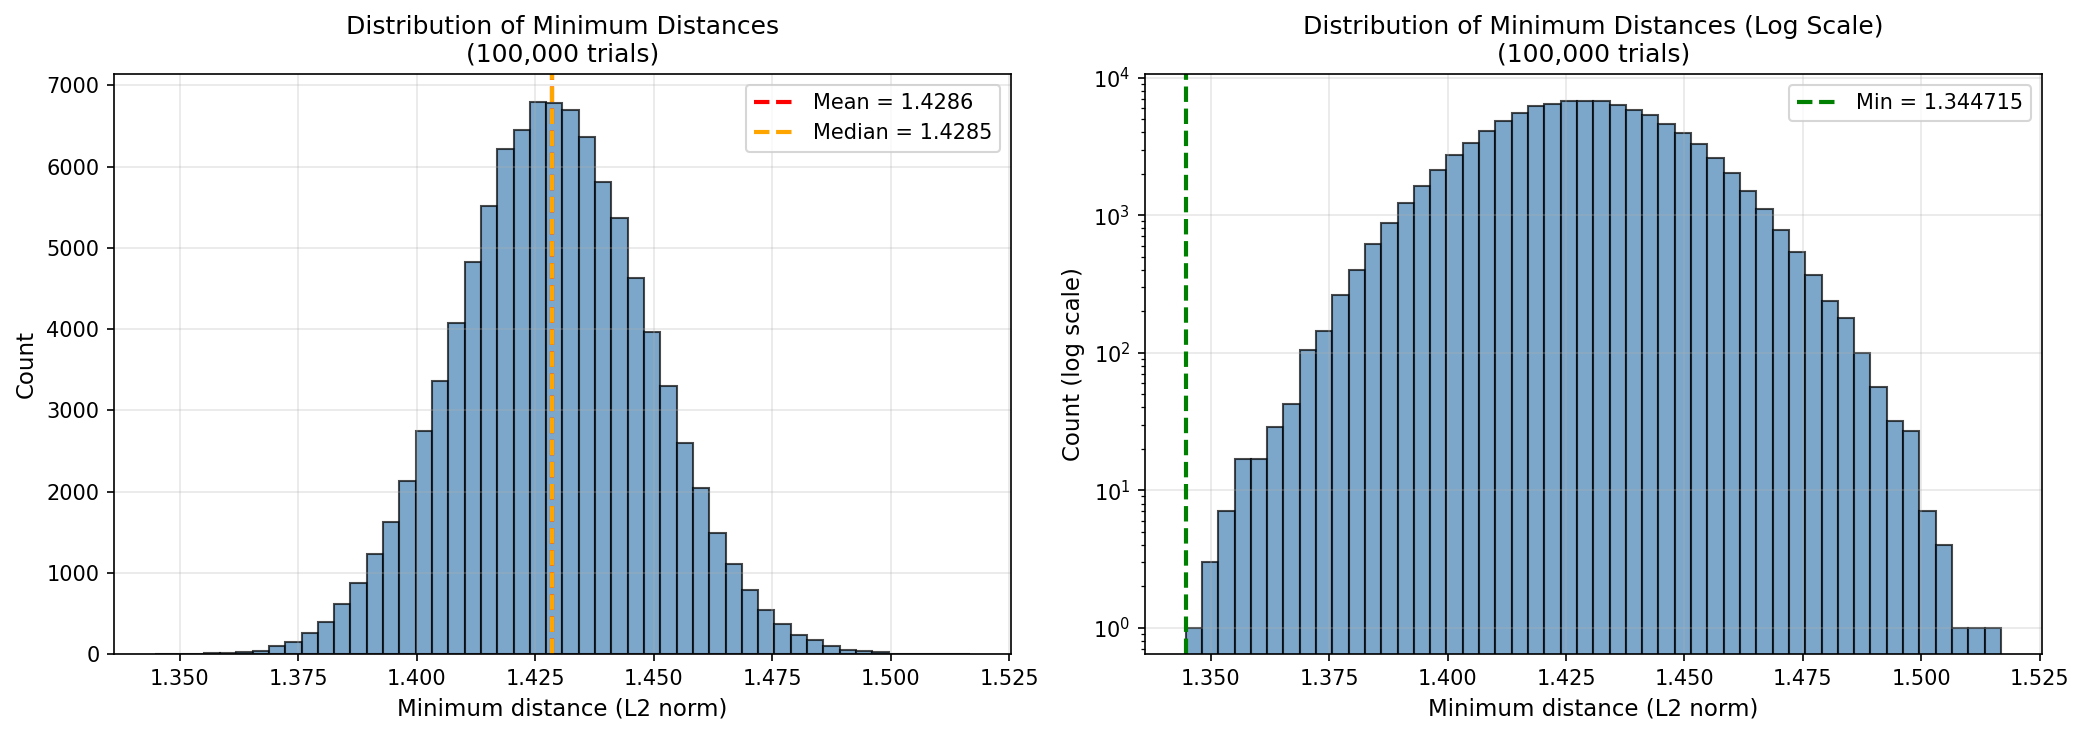

✓ Visualization complete


In [9]:
print(f"\nPlotting minimum distance distribution...\n")

fig, axes = plt.subplots(1, 2, figsize=(14, 5), dpi=PLOT_DPI)

# Linear scale histogram
ax1 = axes[0]
ax1.hist(min_distances_cpu, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
ax1.set_xlabel('Minimum distance (L2 norm)', fontsize=11)
ax1.set_ylabel('Count', fontsize=11)
ax1.set_title(f'Distribution of Minimum Distances\n({N_TRIALS:,} trials)', fontsize=12)
ax1.grid(True, alpha=0.3)
ax1.axvline(min_distances_cpu.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean = {min_distances_cpu.mean():.4f}')
ax1.axvline(np.median(min_distances_cpu), color='orange', linestyle='--', linewidth=2, label=f'Median = {np.median(min_distances_cpu):.4f}')
ax1.legend()

# Log scale histogram (to see tail)
ax2 = axes[1]
ax2.hist(min_distances_cpu, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
ax2.set_xlabel('Minimum distance (L2 norm)', fontsize=11)
ax2.set_ylabel('Count (log scale)', fontsize=11)
ax2.set_title(f'Distribution of Minimum Distances (Log Scale)\n({N_TRIALS:,} trials)', fontsize=12)
ax2.set_yscale('log')
ax2.grid(True, alpha=0.3)
ax2.axvline(min_distances_cpu.min(), color='green', linestyle='--', linewidth=2, label=f'Min = {min_distances_cpu.min():.6f}')
ax2.legend()

plt.tight_layout()
plt.show()

print(f"✓ Visualization complete")

## Collision Times (if any)

In [10]:
if n_collisions > 0:
    print(f"\n{'='*80}")
    print(f"COLLISION TIMES")
    print(f"{'='*80}\n")
    
    collision_times_cpu = collision_times[collisions].cpu().numpy()
    
    print(f"Statistics:")
    print(f"  Earliest: step {collision_times_cpu.min()}")
    print(f"  Latest: step {collision_times_cpu.max()}")
    print(f"  Mean: step {collision_times_cpu.mean():.1f}")
    print(f"  Median: step {np.median(collision_times_cpu):.1f}")
    print()
    
    # Plot collision times
    plt.figure(figsize=(12, 5), dpi=PLOT_DPI)
    plt.hist(collision_times_cpu, bins=50, color='crimson', edgecolor='black', alpha=0.7)
    plt.xlabel('Collision time (step)', fontsize=11)
    plt.ylabel('Count', fontsize=11)
    plt.title(f'When Do Collisions Occur?\n({n_collisions} collisions out of {N_TRIALS:,} trials)', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print(f"\n✓ Collision timing analysis complete")
    print(f"{'='*80}")
else:
    print(f"\nNo collisions detected — no timing analysis needed.")


No collisions detected — no timing analysis needed.


## Summary

In [11]:
print(f"\n{'='*80}")
print(f"SUMMARY")
print(f"{'='*80}\n")
print(f"Monte Carlo simulation: {N_TRIALS:,} trials × {N_STEPS:,} steps")
print(f"  Dimensions: {N_DIMS}")
print(f"  Gradient scale: {GRADIENT_SCALE}")
print(f"  Dtype: bfloat16 (native quantization)")
print()
print(f"Results:")
print(f"  Collisions: {n_collisions} / {N_TRIALS:,} ({probability:.6e})")
print(f"  Min distance achieved: {min_distances_cpu.min():.6f}")
print(f"  Mean min distance: {min_distances_cpu.mean():.6f}")
print()

if n_collisions == 0:
    print(f"Conclusion:")
    print(f"  ✗ TWO-TOKEN COLLISION: Extremely unlikely (P < 10^-6)")
    print(f"  ✗ 814-TOKEN BLACK HOLE: Essentially impossible (P ~ 10^-4878)")
    print(f"  → SPONTANEOUS FORMATION RULED OUT")
    print()
    print(f"Implication:")
    print(f"  Qwen's spongecrystal did NOT form through random-walk accretion.")
    print(f"  It must be either:")
    print(f"    1. Intentional initialization")
    print(f"    2. Accidental (RNG bug, initialization error)")
    print()
    print(f"Next steps:")
    print(f"  - Test broken initialization schemes (low-entropy RNG, etc.)")
    print(f"  - Check other Qwen models for identical spongecrystals")
    print(f"  - Investigate initialization code in transformers library")
else:
    print(f"Conclusion:")
    print(f"  Collisions detected at rate {probability:.6e}")
    print(f"  This may indicate:")
    print(f"    - bfloat16 quantization creates clustering effects")
    print(f"    - Gradient scale allows sufficient exploration")
    print(f"    - High-dimensional space is not as 'empty' as expected")
    print()
    print(f"Further investigation needed!")

print()
print(f"{'='*80}")


SUMMARY

Monte Carlo simulation: 100,000 trials × 10,000 steps
  Dimensions: 2560
  Gradient scale: 0.001
  Dtype: bfloat16 (native quantization)

Results:
  Collisions: 0 / 100,000 (0.000000e+00)
  Min distance achieved: 1.344715
  Mean min distance: 1.428638

Conclusion:
  ✗ TWO-TOKEN COLLISION: Extremely unlikely (P < 10^-6)
  ✗ 814-TOKEN BLACK HOLE: Essentially impossible (P ~ 10^-4878)
  → SPONTANEOUS FORMATION RULED OUT

Implication:
  Qwen's spongecrystal did NOT form through random-walk accretion.
  It must be either:
    1. Intentional initialization
    2. Accidental (RNG bug, initialization error)

Next steps:
  - Test broken initialization schemes (low-entropy RNG, etc.)
  - Check other Qwen models for identical spongecrystals
  - Investigate initialization code in transformers library

